In [1]:
from __future__ import division

import numpy as np
import pylab as plt
from matplotlib import cm

from scipy.constants import m_p, c, e, epsilon_0

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams.update( {
        'axes.labelsize': 'x-large',#24,
        'axes.labelweight': 'bold',
        'axes.linewidth': 2,
        'legend.fancybox': True,
        'legend.fontsize': 'x-large',
        'xtick.labelsize': 'x-large',
        'ytick.labelsize': 'x-large',
        'xtick.major.pad': 14,
        'ytick.major.pad': 14,
        'text.fontsize': 24#,
        #'text.usetex': True

} )

%matplotlib inline

import sys, copy
sys.path.append("../../../")

# from PyHEADTAIL.particles.particles import Particles
from PyHEADTAIL.particles.generators import ParticleGenerator, RF_bucket_distribution, gaussian2D, gaussian2D_asymmetrical
from PyHEADTAIL.particles.slicing import SliceSet, UniformBinSlicer
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems
from PyHEADTAIL.trackers.rf_bucket import RFBucket
from PyHEADTAIL.spacecharge.spacecharge import LongSpaceCharge

from functools import partial

PyHEADTAIL v1.6.0-1-gb6824eb4bd-dirty




/home/giadarol/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Machine parameters

In [2]:
circ   = 6911.
R      = circ/(2*np.pi)
alpha  = 18**-2 # i.e. E_transition = 18 * m_p * c**2 = 16.89e9

energy = 26e9#10e9#
gamma  = energy/(m_p/e*c**2)
p0     = m_p*np.sqrt(gamma**2-1)*c

eta    = alpha - gamma**-2
V      = [4e6, 0e5]
h      = [4620, 18480]
if eta > 0:
    phi = np.array([0, 0])
else:
    phi = np.array([np.pi, np.pi])
phi_offset = np.array([0, 0])
phi += phi_offset
intensity = 4e11#4e12#
sigx = 1e-4
sigy = 1e-4
sigz = 0.23 * 0.5
sigdp = 1e-3

## Acceleration

In [3]:
beta          = np.sqrt(1-1/gamma**2)
normalisation = 1/circ * e * circ/(beta*c)
dp_increment   = 1e6 * normalisation/p0
T0            = circ/(beta*c)

## Analytic functions

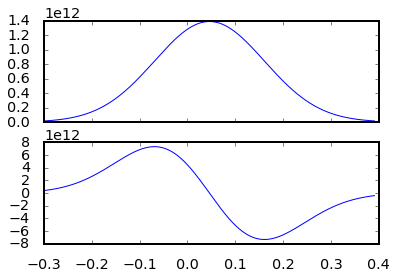

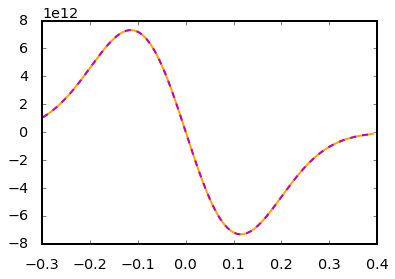

In [4]:
threshold = 1e-10
def lambda_(z, z_offset=0):
    z = np.atleast_1d(z - z_offset)
    value = intensity / (np.sqrt(2*np.pi)*sigz) * np.exp(-z**2/(2*sigz**2))
    empty = np.zeros(len(value))
    clean = np.where(value > threshold, value, empty)
    clean[np.logical_and(z < 0, clean == 0)] -= threshold
    clean[np.logical_and(z >= 0, clean == 0)] += threshold
    return clean

def lambda_prime(z, z_offset=0):
    z = np.atleast_1d(z - z_offset)
    value = -intensity / (np.sqrt(2*np.pi) * sigz**3) * z * np.exp(-z**2/(2*sigz**2))
    empty = np.zeros(len(value))
    clean = np.where(lambda_(z) > threshold, value, empty)
    clean[np.logical_and(z < 0, clean == 0)] -= threshold
    clean[np.logical_and(z >= 0, clean == 0)] += threshold
    return clean

fig, (axl1, axl2) = plt.subplots(2, 1, sharex=True)
z_offset = 0.4*sigz
zz = np.linspace(z_offset-3*sigz, z_offset+3*sigz, 1000)
axl1.plot(zz, lambda_(zz, z_offset))
axl2.plot(zz, lambda_prime(zz, z_offset))
plt.show()

plt.plot(zz, np.gradient(lambda_(zz), zz[1]-zz[0]), 'orange', lw=2)
plt.plot(zz, lambda_prime(zz), '--m', lw=2)
plt.show()

## Preparation of Objects

In [6]:
n_slices = 400
macroparticlenumber = 5e4

epsn_z = sigz * sigdp * 4 * np.pi * p0/e
# p_increment = 77.7586635e9 * e/c * circ/(beta * c)
p_increment = dp_increment * p0

slicer = UniformBinSlicer(n_slices, n_sigma_z=4)
# beam = Gaussian(macroparticlenumber, intensity, e, m_p, circ, gamma, 
#                 {'z': sigz, 'dp': sigdp, 'x': sigx, 'y': sigy}).generate()

beam = ParticleGenerator(macroparticlenumber, intensity, e, m_p, circ, gamma, 
                        distribution_x=gaussian2D(sigx),
                        distribution_y=gaussian2D(sigy),
                        distribution_z=gaussian2D_asymmetrical(sigz, sigdp)).generate()


long_sc = LongSpaceCharge(slicer, 5e-2, circ)

longitudinal_map = RFSystems(circ, h, V, phi, [alpha], gamma, p_increment=p_increment, charge=e, mass=m_p)
rfbucket = longitudinal_map.get_bucket(beam)
rfbucket_wosc = copy.deepcopy(rfbucket)

beam.z += rfbucket.z_sfp_extr
print 'beam.mean_z    = %e\nrfbucket.z_sfp = %e' % (beam.mean_z(), rfbucket.z_sfp)
print ''
print 'beam.epsn_z    = %e\nnominal epsn_z = %e' % (beam.epsn_z(), epsn_z)
slices = beam.get_slices(slicer, statistics=['sigma_x', 'sigma_y'])

rfbucket.add_fields([long_sc.make_force(slices)], [long_sc.make_potential(slices)])

beam.mean_z    = 5.988110e-02
rfbucket.z_sfp = 6.015758e-02

beam.epsn_z    = 1.249265e-01
nominal epsn_z = 1.252499e-01


## Plot Results

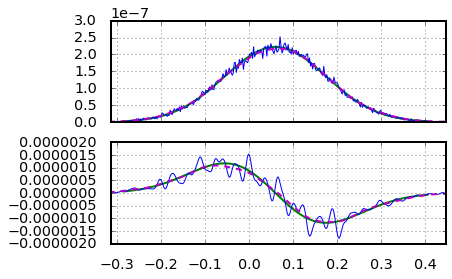

In [7]:
num = 2000
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

zz = np.linspace(beam.mean_z() - 3*sigz, beam.mean_z() + 3*sigz, num)

ax1.plot(zz, lambda_(zz, beam.mean_z()) * e, 'green', lw=2)
ax1.plot(slices.z_centers, 
         slices.n_macroparticles_per_slice * beam.particlenumber_per_mp / 
             slices.slice_widths * beam.charge, 
         'blue')
ax1.plot(slices.z_centers, slices.lambda_z(slices.z_centers), '--m', lw=2)
ax1.grid(True)

ax2.plot(zz, lambda_prime(zz, beam.mean_z()) * e, 'green', lw=2)
ax2.plot(slices.z_centers, 
         slices.lambda_prime_bins(sigma=2) / slices.slice_widths, 'blue')
ax2.plot(slices.z_centers, slices.lambda_prime_z(slices.z_centers), '--m', lw=2)
ax2.grid(True)

plt.xlim(zz[0]*1.1, zz[-1]*1.1)

plt.show()

In [8]:
# ppmax = np.maximum(rfbucket.separatrix(rfbucket.z_sfp_extr), 
#                rfbucket_wosc.separatrix(rfbucket_wosc.z_sfp_extr))
# print (rfbucket.separatrix(rfbucket.z_sfp_extr), 
#        rfbucket_wosc.separatrix(rfbucket_wosc.z_sfp_extr), ppmax)
ppmax = np.maximum(rfbucket.dp_max(rfbucket.z_ufp_separatrix), 
                rfbucket_wosc.dp_max(rfbucket.z_ufp_separatrix))
print ppmax
pp = np.linspace(-ppmax, ppmax, num)
print rfbucket.z_sfp, rfbucket.separatrix(rfbucket.z_sfp)

zz = np.linspace(*rfbucket.interval, num=num)
ZZ, PP = np.meshgrid(zz, pp)
orig_shape = ZZ.shape
ZZ = ZZ.reshape(-1)
PP = PP.reshape(-1)
hh = rfbucket.hamiltonian(ZZ, PP, make_convex=True)
ZZ = ZZ.reshape(orig_shape)
PP = PP.reshape(orig_shape)
hh = hh.reshape(orig_shape)

hc = rfbucket.separatrix
hc_wosc = rfbucket_wosc.separatrix

ap = []
ap.append(rfbucket.zleft)
ap += list(rfbucket.z_sfp)
ap += list(rfbucket.z_ufp)
ap.append(rfbucket.zright)
if p_increment == 0:
    ap.append(np.pi-rfbucket.z_sfp_extr)
    
ac = ['purple'] + ['orange']*len(rfbucket.z_sfp) + ['red']*len(rfbucket.z_ufp) + ['b']
if rfbucket.eta0 * rfbucket.p_increment < 0:
    ac[0], ac[-1] = ac[-1], ac[0]

# zz_bucket = zz[np.logical_and(zz>=np.min(ap), zz<=np.max(ap))]
# zz_bucket_wosc = zz[np.logical_and(rfbucket_wosc.zleft < zz, zz < rfbucket_wosc.zright)]

zz_bucket = zz[rfbucket.is_in_separatrix(zz, 0, margin=-0.001)]
zz_bucket_wosc = zz[rfbucket_wosc.is_in_separatrix(zz, 0, margin=-0.001)]

figtitle = ""
if eta > 0:
    figtitle += "$\eta > 0$ and "
elif eta < 0:
    figtitle += "$\eta < 0$ and "
else:
    figtitle += "$\eta = 0$ and "
if dp_increment > 0:
    figtitle += "${\Delta}p > 0$"
elif dp_increment < 0:
    figtitle += "${\Delta}p < 0$"
else:
    figtitle += "${\Delta}p = 0$"

0.00283183380683
[ 0.06123971] [ 0.00283183]


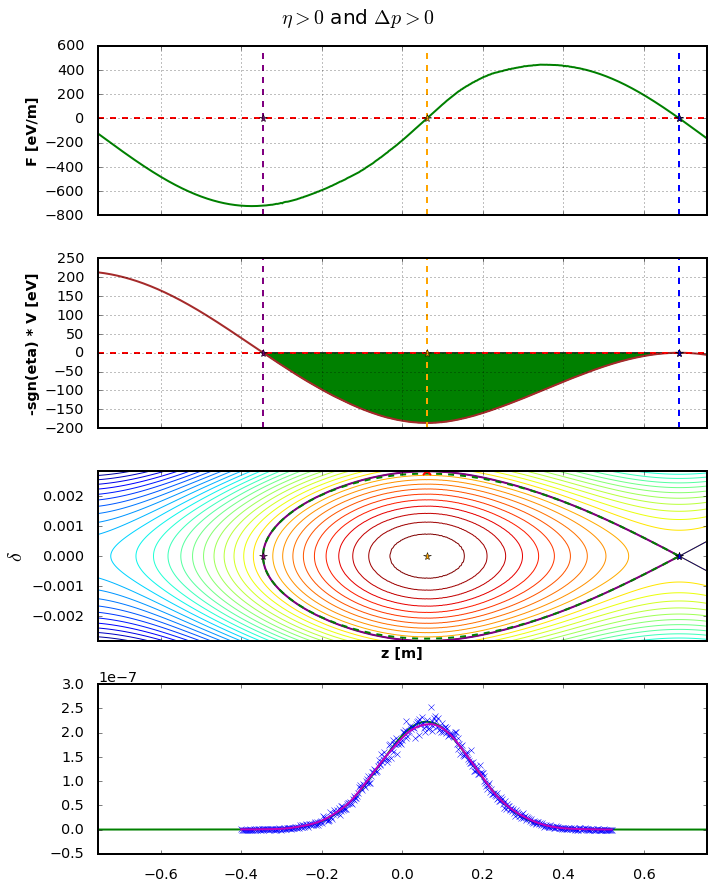

In [9]:
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10,12), sharex=True)

ax1.plot(zz, rfbucket.acc_force(zz)/e, 'g', lw=2)
ax1.set_ylabel('F [eV/m]')
ax1.grid()

ax2.plot(zz, -np.sign(rfbucket.eta0) * rfbucket.acc_potential(zz)/e, 'brown', lw=2)
ax2.fill_between(zz_bucket, -np.sign(rfbucket.eta0) * rfbucket.acc_potential(zz_bucket)/e, 
                 0, facecolor='green', interpolate=True)
ax2.set_ylabel('-sgn(eta) * V [eV]')
ax2.grid()

ax3.contour(ZZ, PP, hh, 40)#, cmap=cm.Accent)
ax3.contour(ZZ, PP, hh, levels=[0], c='purple')
ax3.plot(zz_bucket, +hc(zz_bucket), c='purple', lw=2)
ax3.plot(zz_bucket, -hc(zz_bucket), c='purple', lw=2)
ax3.plot(zz_bucket_wosc, +hc_wosc(zz_bucket_wosc), '--g', lw=2)
ax3.plot(zz_bucket_wosc, -hc_wosc(zz_bucket_wosc), '--g', lw=2)
ax3.set_xlabel('z [m]')
ax3.set_ylabel('$\delta$', fontsize=20)

for ax in ax1, ax2:
    ax.axhline(0, c='r', ls='--', lw=2)
    for p, cl in zip(ap, ac):
        ax.axvline(p, c=cl, ls='--', lw=2)
for p, cl in zip(ap, ac):
    ax1.plot(p, rfbucket.acc_force(p), '*', c=cl, ms=8)
    ax2.plot(p, -np.sign(eta) * rfbucket.acc_potential(p), '*', c=cl, ms=8)
    ax3.plot(p, 0, '*', c=cl, ms=8)

ax4.plot(zz, lambda_(zz, beam.mean_z()) * e, 'green', lw=2)
ax4.plot(slices.z_centers, slices.lambda_z(slices.z_centers, smoothen=False), 'xb')
ax4.plot(slices.z_centers, slices.lambda_z(slices.z_centers), 'm', lw=2)

# [ax3.annotate(t, (p,0), (-40, -70), textcoords='offset points', color=cl, fontsize=22,
#               bbox=dict(boxstyle="round", fc="1"),
#               arrowprops=dict(arrowstyle="fancy",
#                               fc="0.6", ec="none",
#                               connectionstyle="angle3,angleA=0,angleB=-90")) 
# for t, p, cl in zip(at, ap, ac)]
ax3.plot(ap[1], hc(ap[1]), 'x', c='r', ms=8, mew=2)
# ax3.annotate(r'$\delta_{max}$', (ap[1], hc(ap[1])), (50, 25), textcoords='offset points', 
# color='r', fontsize=22,
#              bbox=dict(boxstyle="round", fc="1"),
#              arrowprops=dict(arrowstyle="fancy",
#                              fc="0.6", ec="none",
#                              connectionstyle="angle3,angleA=0,angleB=-90"))

plttitle = plt.suptitle(figtitle, y=1.025, fontsize=20)

plt.xlim(rfbucket.interval)

plt.tight_layout()

# plt.savefig('bucket.pdf', bbox_extra_artists=(plttitle,), bbox_inches='tight')

plt.show()

# Intensity Matching -- First Trials

In [13]:
matched_beam = copy.deepcopy(beam)
#matchor = MatchRFBucket2D(macroparticlenumber, intensity, e, m_p, circ, gamma, rfbucket, sigma_z=sigz)
matchor = ParticleGenerator(macroparticlenumber, intensity, e, m_p, circ, gamma, 
                            distribution_z=RF_bucket_distribution(rfbucket, sigma_z=sigz))

matchor.update(matched_beam)

*** Maximum RMS bunch length 0.177944768103m.
... distance to target bunch length: 7.4462e-04
... distance to target bunch length: 8.5245e-04
... distance to target bunch length: -4.6254e-06
... distance to target bunch length: 2.5445e-08
... distance to target bunch length: 7.8540e-13
--> Bunch length: 0.115
--> Emittance: 0.100682956974


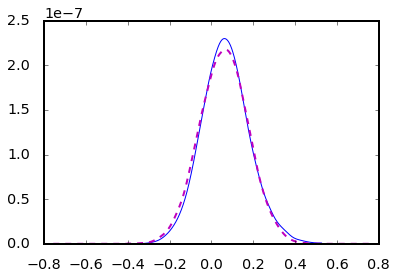

In [14]:
matched_beam.clean_slices()
plt.plot(zz, matched_beam.get_slices(slicer).lambda_z(zz))
plt.plot(zz, beam.get_slices(slicer).lambda_z(zz), '--m', lw=2)
plt.show()